https://github.com/partytax/ncei-api-guide

In [5]:
import pandas as pd
import xarray as xr
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
from dask.distributed import Client, progress
from eofs.xarray import Eof
from eofs.examples import example_data_path


In [8]:
# Sets up a local cluster on keeling and a tmp directory for dask processes
dask.config.set(temporary_directory='/data/keeling/a/leanneb2/tmp/leanneb2-dask/')  
client = Client()  
client

/data/keeling/a/leanneb2/miniconda3/envs/py3-eofs/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45527 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45527/status,
Dashboard: http://127.0.0.1:45527/status,Workers: 8
Total threads: 40,Total memory: 503.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35404,Workers: 8
Dashboard: http://127.0.0.1:45527/status,Total threads: 40
Started: Just now,Total memory: 503.48 GiB
Comm: tcp://127.0.0.1:45908,Total threads: 5
Dashboard: http://127.0.0.1:40674/status,Memory: 62.94 GiB
Nanny: tcp://127.0.0.1:44036,


In [9]:
# Make garbage collection explicit to prevent deadlocks
import gc
from distributed import WorkerPlugin

class WorkerExplicitGC(WorkerPlugin):
    def setup(self, worker):
        self.worker = worker
        gc.disable()             

    def transition(self, key, start, finish, *args, **kwargs):
       if finish == 'executing':
          self.worker._throttled_gc.collect()
          if gc.isenabled():
             gc.disable()

plugin = WorkerExplicitGC()
client.register_worker_plugin(plugin)

{'tcp://127.0.0.1:33751': {'status': 'OK'},
 'tcp://127.0.0.1:33796': {'status': 'OK'},
 'tcp://127.0.0.1:34391': {'status': 'OK'},
 'tcp://127.0.0.1:36210': {'status': 'OK'},
 'tcp://127.0.0.1:37385': {'status': 'OK'},
 'tcp://127.0.0.1:40431': {'status': 'OK'},
 'tcp://127.0.0.1:42759': {'status': 'OK'},
 'tcp://127.0.0.1:45908': {'status': 'OK'}}

1. Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and precipitation anomalies from Jan 1979-Dec 2021 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. 

    The [Computations and Masks with Xarray documentation from Project Pythia](https://foundations.projectpythia.org/core/xarray/computation-masking.html) was used for help on calculating the SST and precipitation anomalies.

In [10]:
# This builds a file list of ERA5 monthly mean SST files and accumulated precipitation
# from 1979-2021 (files are for every year but contain monthly means)
base_url_sst = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
base_url_precip = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/'
base_url2_sst = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base_url2_precip = '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'
base_url3 = '.nc'

# Pandas fuction that creates an array of date time objects with an annual frequency
# during the period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list_sst=[]
file_list_precip = []
for dt in pr:
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # Builds complete file name and appends it to a list of files that need to
    # be downloaded for each variable
    single_file_sst = (base_url_sst+year+base_url2_sst+month+'_'+month2+base_url3)
    file_list_sst.append(single_file_sst)

    single_file_precip = (base_url_precip+year+base_url2_precip+month+'_'+month2+base_url3)
    file_list_precip.append(single_file_precip)

In [11]:
# Defines Pacific Ocean latitude and longitude basin wanted
pacific_north_lat = 65.0
pacific_south_lat = -65.0
pacific_east_lon = 120.0
pacific_west_lon = 300.0

# Creates a dask array for the sst and precip variables
ds_sst = xr.open_mfdataset(file_list_sst, parallel=True, chunks={'time': '100MB'}).sel(
    latitude=slice(pacific_north_lat,pacific_south_lat,1), longitude=slice(pacific_east_lon, pacific_west_lon,1))
ds_precip = xr.open_mfdataset(file_list_precip, parallel=True, chunks={'time': '100MB'}).sel(
    latitude=slice(pacific_north_lat,pacific_south_lat,1), longitude=slice(pacific_east_lon, pacific_west_lon,1))

2022-10-21 10:07:54,345 - distributed.worker - WARNING - Compute Failed
Key:       open_dataset-c13b0455-6d84-4c19-b4ea-a8d7bd2c3e8f
Function:  execute_task
args:      ((<function apply at 0x2af2bf1c4dc0>, <function open_dataset at 0x2af2d87003a0>, ['https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1981/e5.moda.an.sfc.128_034_sstk.ll025sc.1981010100_1981120100.nc'], (<class 'dict'>, [['engine', None], ['chunks', (<class 'dict'>, [['time', '100MB']])]])))
kwargs:    {}
Exception: "OSError(-54, 'NetCDF: NC_UNLIMITED size already in use')"



OSError: [Errno -54] NetCDF: NC_UNLIMITED size already in use: b'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1981/e5.moda.an.sfc.128_034_sstk.ll025sc.1981010100_1981120100.nc'

In [12]:
ds_precip

<xarray.Dataset>
Dimensions:    (latitude: 521, longitude: 721, time: 516)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    utc_date   (time) int32 dask.array<chunksize=(12,), meta=np.ndarray>
    TP         (time, latitude, longitude) float32 dask.array<chunksize=(12, 521, 721), meta=np.ndarray>
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper02 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon Nov 11 08:45:33 MST 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon Nov 11 08:45:34 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

In [13]:
ds_sst.SSTK

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
dask.array<getitem, shape=(516, 521, 721), dtype=float32, chunksize=(12, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Attributes: (12/15)
    long_name:                     Sea surface temperature
    short_name:                    sstk
    units:                         K
    original_format:               WMO GRIB 1 with ECMWF local table
    ecmwf_local_table:             128
    ecmwf_parameter:               34
    ...                            ...
    rda_dataset:                   ds633.1
    rda_dataset_url:               https:/rda.ucar.edu/datasets/ds633.1/
    rda_dataset_doi:               DOI: 10.5065/P8GT-0R61
    rda_dataset_group:             ERA5 monthly mean atmospheric surface anal...
    number_of_significant_digits:  7
    _ChunkSizes:                   [  3 389 776]

In [14]:
# Computes the monthly mean SST and precip anomalies at each latitude and longitude box for 
# each year
monthly_mean_sst_ano = ds_sst.SSTK.groupby('time.month') - ds_sst.SSTK.groupby('time.month').mean(dim='time').compute()
monthly_mean_precip_ano = ds_precip.TP.groupby('time.month') - ds_precip.TP.groupby('time.month').mean(dim='time').compute()

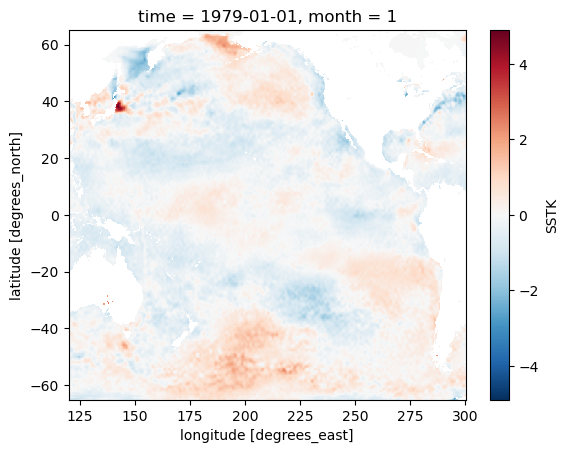

In [15]:
# Quickly plotting the monthly mean SST anomalies at one time step
monthly_mean_sst_ano.sel(time='1979-01', method='nearest').plot()

2. From the dataset shown in 1, deseasonalize (remove the mean monthly anomaly from the annual mean from each point), detrend, and standardize the SST anomalies.
Deseasonalization as defined here is subtracting the long term monthly mean from each month in the time series at every point in the dataset.  Your input dimensions and output dimensions will not change - it will still be time, lat, lon

    The [Monthly data analysis — PyCLIM_101 0.2 documentation](https://climate.usu.edu/people/yoshi/pyclm101/monthly.html) was used for the detrend function
    
    The [Xarray documentation](https://docs.xarray.dev/en/stable/examples/weather-data.html) was used to standardize the monthly anomalies.

In [16]:
# Deseasonalizing the SST anomalies
deseason_sst = ds_sst.SSTK.groupby('time.month') - ds_sst.SSTK.groupby('time.month').mean(dim='time')
deseason_sst

/data/keeling/a/leanneb2/miniconda3/envs/py3-eofs/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
dask.array<sub, shape=(516, 521, 721), dtype=float32, chunksize=(1, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [17]:
# This function is used to detrend the SST anomalies

def detrend_dim(da, dim, deg=1):
    '''This function detrends a data array along a single dimension'''
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

detrend_sst = detrend_dim(deseason_sst, dim='time', deg=1)
detrend_sst

<xarray.DataArray (time: 516, latitude: 521, longitude: 721)>
dask.array<sub, shape=(516, 521, 721), dtype=float64, chunksize=(1, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [10]:
# This standardizes the monthly SST anomalies using a lambda function
# First, we subtract the time mean of the dataset from the time series at each lat 
# lon point, and then divide by the standard deviation at each lat lon point over all time 
climo_mean_sst = ds_sst.groupby('time.month').mean('time')
climo_std_sst = ds_sst.groupby('time.month').std('time')
stand_ano_sst = xr.apply_ufunc(lambda x, m, s: (x - m) / s, ds_sst.groupby("time.month"), 
    climo_mean_sst, climo_std_sst, dask="parallelized")

In [11]:
# Computed the standardized monthly SST anomalies because it was a dask array; 
# now it is a xarray dataarray
computed_stand_ano_sst = stand_ano_sst.SSTK.compute()

/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/keeling/a/leanneb2/miniconda3/envs/ml_i

In [ ]:
# Checking the standardized monthly anomalies of SST by looking at a strong El Nino event
stand_ano_sst.SSTK.sel(time='1997-12-01', method='nearest').plot()

3. Perform an EOF analysis (with cosine latitude weighting) on the SST anomalies and plot a map of the first 5 EOFs.

In [12]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs. Dropping the
# month coordinates first
no_month_computed_stand_ano_sst = computed_stand_ano_sst.drop('month')

coslat = np.cos(np.deg2rad(no_month_computed_stand_ano_sst.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(no_month_computed_stand_ano_sst, weights=wgts)

In [13]:
# Retrieve the first 5 EOFs, expressed as the correlation between the
# PC time series and the input SST anomalies at each grid point, and the
# PC time series itself.
eofs = solver.eofs(neofs=5)
#pc1 = solver.pcs(npcs=5, pcscaling=1)


/tmp/ipykernel_63683/1813768845.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0.05, wspace=0.05)


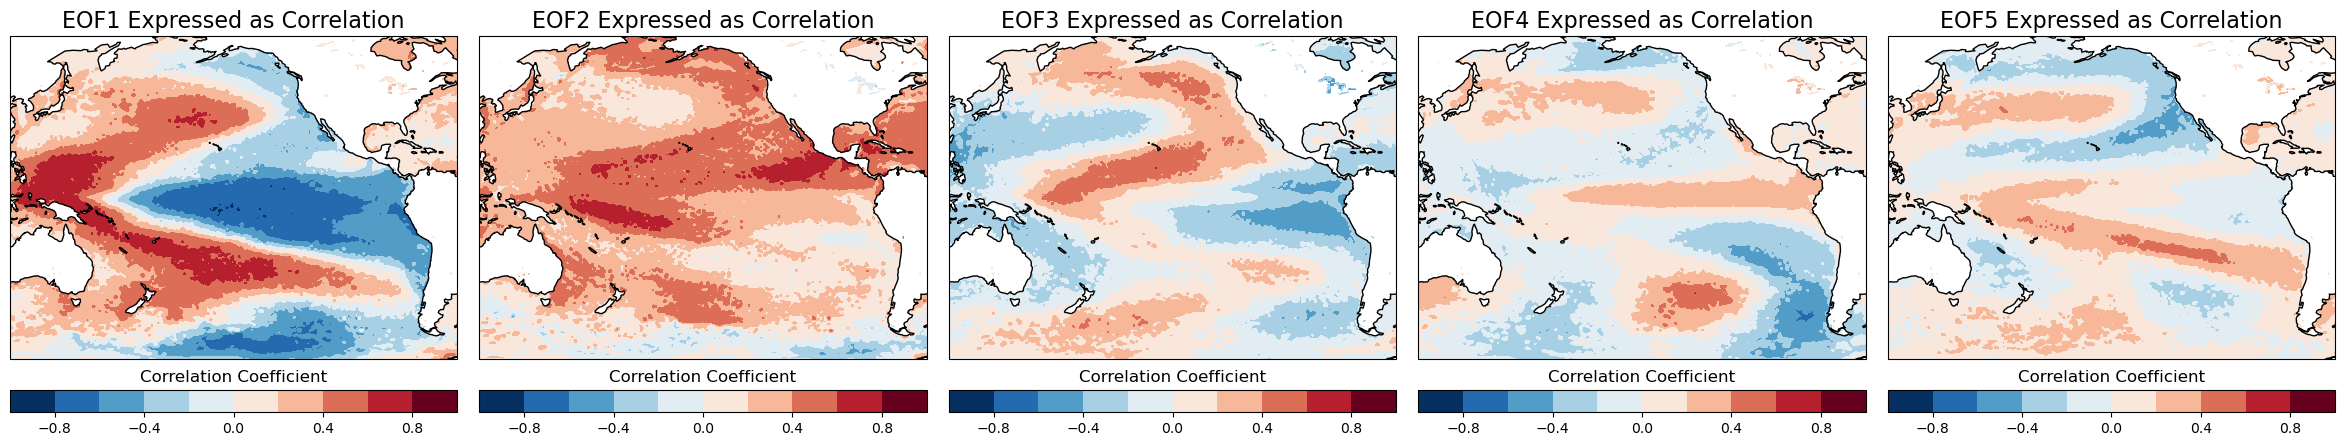

In [45]:
# Creating plots of the first 5 EOFs
clevs = np.linspace(-1, 1, 11)
fig = plt.figure(figsize=(30, 20), constrained_layout=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)
for num in range(1,6):
    ax = plt.subplot(1, 5, num,  projection=ccrs.PlateCarree(central_longitude=190))
    fill = eofs[num-1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                                add_colorbar=False, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    ax.set_title(f'EOF{num} Expressed as Correlation', fontsize=16)
    clb = fig.colorbar(fill, ax=ax, orientation='horizontal', pad=0.02)
    clb.ax.set_title('Correlation Coefficient')
plt.show()

4. Plot the percent of variance explained by the first 10 EOFs.

In [ ]:
# Calculating the percent of variance for the EOFs
varfrac = solver.varianceFraction()

In [ ]:
# Plotting the percent of variance explained by the first 10 EOFs
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10]*100, linewidth=2)
plt.plot(eof_num, varfrac[0:10]*100, linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(eof_num)
plt.title('Percent of the Total Variance Represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Percent of the Total Variance')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac*100), np.max(varfrac*100)+0.01)

5. Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient of the reconstructed monthly time series and the "observed" SST time series.

In [47]:
reconstructed_sst = solver.reconstructedField(5)

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 563, in _pydevd_bundle.pydevd_cython.PyDBFrame._handle_exception
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1976, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/data/keeling/a/leanneb2/miniconda3/envs/ml_intro/lib/python3.10/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2011, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


AttributeError: module 'collections' has no attribute 'Iterable'

In [ ]:
cc_sst = xr.corr(reconstructed_sst, monthly_mean_sst_ano, dim="time")

In [ ]:
# # Plot the leading EOF expressed as correlation in the Pacific domain.
# clevs = np.linspace(-3, 3, 21)
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
# fill = reconstruction.sel(time='1998-01-15', method='nearest').plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
#                              add_colorbar=False, transform=ccrs.PlateCarree())
# ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
# cb = plt.colorbar(fill, orientation='horizontal')
# cb.set_label('SST Anomalies (reconstructed)', fontsize=12)

In [ ]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-3, 3, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = sst.sel(time='1998-01-15', method='nearest').plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('SST Anomalies observed', fontsize=12)

6. Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean precipitation anomalies (don't mask these over land for the plot). See anything interesting?

In [ ]:
# This loads monthly precip data
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.meanflux/'
base_url2 = '/e5.moda.fc.sfc.meanflux.235_030_mcpr.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list.append(single_file)

ds_cpr = xr.open_mfdataset(file_list_precip, parallel=True, chunks={'time': '100MB'}).sel(
    latitude=slice(pacific_north_lat,pacific_south_lat,1), longitude=slice(pacific_east_lon, pacific_west_lon,1))
# ds_cpr = xr.open_mfdataset(file_list, parallel=True, engine='netcdf4').\
#     sel(longitude=slice(120.,360.-60.,4), latitude=slice(65.,-65.,4))

base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.meanflux/'
base_url2 = '/e5.moda.fc.sfc.meanflux.235_029_mlspr.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list.append(single_file)
ds_lspr = xr.open_mfdataset(file_list_precip, parallel=True, chunks={'time': '100MB'}).sel(
    latitude=slice(pacific_north_lat,pacific_south_lat,1), longitude=slice(pacific_east_lon, pacific_west_lon,1))
# ds_lspr = xr.open_mfdataset(file_list, parallel=True, engine='netcdf4').\
#     sel(longitude=slice(120.,360.-60.,4), latitude=slice(65.,-65.,4))

ds_precip_part6 = ds_lspr['MLSPR'] + ds_cpr['MCPR']

In [ ]:
# Detrended, deseasonalized, and standardized monthly mean precipitation anomalies
deseason_precip_part6 = ds_precip_part6.VAR.groupby('time.month') - ds_precip_part6.VAR.groupby('time.month').mean(dim='time')
detrend_precip_part6 = detrend_dim(deseason_precip_part6, dim='time', deg=1)
climo_mean_precip_part6 = ds_precip_part6.groupby('time.month').mean('time')
climo_std_precip_part6 = ds_precip_part6.groupby('time.month').std('time')
stand_ano_precip_part6 = xr.apply_ufunc(lambda x, m, s: (x - m) / s, ds_precip_part6.groupby("time.month"),
    climo_mean_precip_part6, climo_std_precip_part6, dask="parallelized")

# Computed the SST dask array so now it is a xarray dataarray
computed_stand_ano_precip_part6 = stand_ano_precip_part6.VAR.compute()

In [ ]:
# Calculating the Pearson's CC between SST EOF1 and and standardized monthly mean precipitation anomalies
xr.corr(solver.reconstructedField(1), computed_stand_ano_precip_part6, dim="time")

In [ ]:
client.close()

In [ ]:
# Getting the file that we want to mask our SST data with, selecting out the Pacific 
# domain we want
land_sea_mask = xr.open_dataset('https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc',
                      engine='netcdf4')
pacific_domain_lsm = land_sea_mask['LSM'].sel(latitude=slice(pacific_north_lat,pacific_south_lat,1), longitude=slice(pacific_east_lon, pacific_west_lon,1))
#pacific_domain_lsm = land_sea_mask.sel(latitude=slice(pacific_north_lat,pacific_south_lat,1), longitude=slice(pacific_east_lon, pacific_west_lon,1))

In [ ]:
# Dropping the time dimension from the LSM datarray, adding a new time dimension
# to it so the LSM dataarray is the same size as the SST dataarray, and masking
# the SST dataarray where there is land
lsm_dropped_time = pacific_domain_lsm.squeeze('time')
sst_times = pd.date_range(start='1979-01-01',end='2021-12-31', freq='MS')
lsm_all_times = lsm_dropped_time.expand_dims(dim={"time": ds_sst.time})
lsm_all_times
# masked_sst = ds_sst.where(lsm_all_times == 1, np.nan)
masked_sst = np.ma.masked_where(lsm_all_times == 1, ds_sst.SSTK)